<a href="https://colab.research.google.com/github/borhanur-rahman/Dengu_Biomarker_Discovery/blob/main/Dengue_Biomarker_Discovery_Using_ScRNASeq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages (quiet mode to avoid clutter)
!pip install scanpy anndata scikit-learn pandas numpy matplotlib seaborn -q
print("Packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 70.4 MB/s eta 0:00:00
Packages installed!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Optional: for nicer plots
%matplotlib inline
sns.set(style="whitegrid")
print("Libraries imported!")

Libraries imported!


In [7]:
# Change this path to match where you uploaded the file in Drive
h5ad_path = '/content/drive/MyDrive/BioInfoResearch/GSE220969_dengue_kids.h5ad'

# Load the AnnData object
adata = sc.read_h5ad(h5ad_path)
print("Data loaded successfully!")
print(adata)  # Shows number of cells, genes, etc.

# VERY IMPORTANT: Check metadata columns
print("\nAvailable metadata columns in adata.obs:")
print(adata.obs.columns.tolist())

# Show value counts for potential group/severity columns (run this and see what appears)
potential_group_cols = ['severity', 'progressor', 'group', 'condition', 'disease_status', 'status', 'phenotype', 'disease']
for col in potential_group_cols:
    if col in adata.obs.columns:
        print(f"\n{col} value counts:")
        print(adata.obs[col].value_counts())

Data loaded successfully!
AnnData object with n_obs × n_vars = 193727 × 37907
    obs: 'cell_type', 'cell_subtype', 'ID', 'age', 'condition', 'sex', 'DENV_reads', 'mt_frac', 'n_counts', 'n_genes', 'cell_quality', 'doublets', 'batch'

Available metadata columns in adata.obs:
['cell_type', 'cell_subtype', 'ID', 'age', 'condition', 'sex', 'DENV_reads', 'mt_frac', 'n_counts', 'n_genes', 'cell_quality', 'doublets', 'batch']

condition value counts:
condition
dengue      86862
S_dengue    60061
DWS         25182
Healthy     21622
Name: count, dtype: int64


In [22]:
# Use the subset from earlier DEGs (only dengue + S_dengue)
# If you don't have adata_subset yet, create it:
group_column = 'condition'
mask = adata.obs[group_column].isin(['dengue', 'S_dengue'])
adata_subset = adata[mask].copy()
print("Subset shape:", adata_subset.shape)

# For speed: Downsample to 20k–30k cells (still representative)
sc.pp.subsample(adata_subset, n_obs=25000, random_state=42)
print("Downsampled subset shape:", adata_subset.shape)

# Normalize/log if needed (skip if already processed)
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

# Compute PCA (fast step)
sc.tl.pca(adata_subset, svd_solver='arpack', n_comps=50)

# Compute neighbors FASTER: use sklearn (brute force) instead of pynndescent
sc.pp.neighbors(
    adata_subset,
    n_neighbors=15,
    n_pcs=30,
    transformer='sklearn',      # <-- key: avoids pynndescent crash/slowdown
    metric='euclidean'
)

# UMAP
sc.tl.umap(adata_subset)

print("Neighbors + UMAP computed successfully!")

Subset shape: (146923, 37907)
Downsampled subset shape: (25000, 37907)
Neighbors + UMAP computed successfully!


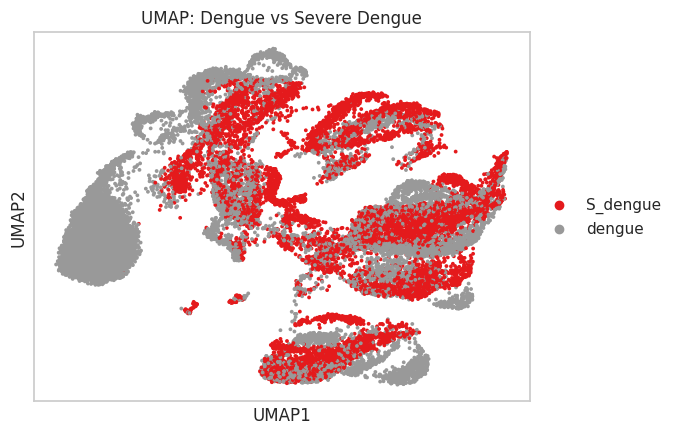

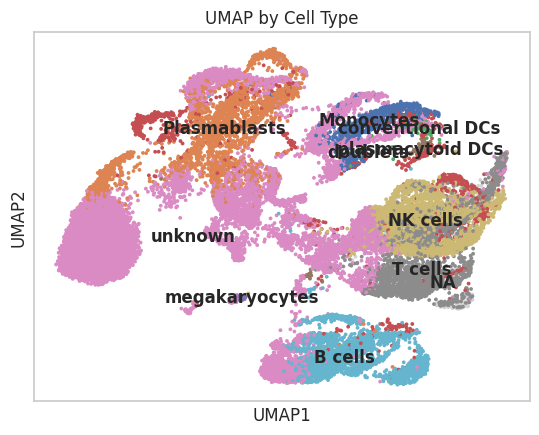

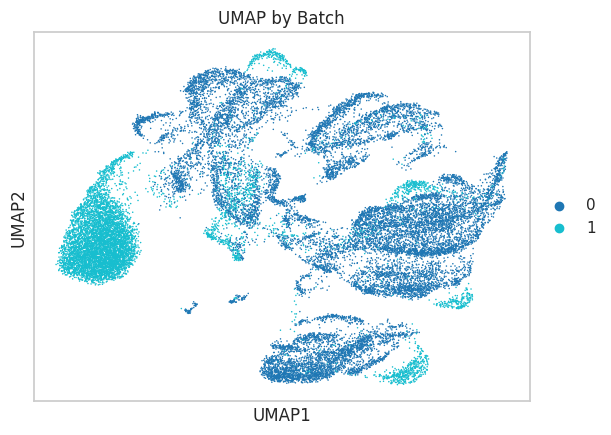

In [23]:
# UMAP by condition
sc.pl.umap(
    adata_subset,
    color='condition',
    palette='Set1',
    title='UMAP: Dengue vs Severe Dengue',
    size=30,
    show=True
)

# UMAP by cell type
sc.pl.umap(
    adata_subset,
    color='cell_type',
    legend_loc='on data',
    title='UMAP by Cell Type',
    size=30,
    show=True
)

# UMAP by batch (check for batch effects)
sc.pl.umap(
    adata_subset,
    color='batch',
    title='UMAP by Batch',
    palette='tab10',
    show=True
)

In [13]:
# Use the correct column we already know
group_column = 'condition'
severe_group   = 'S_dengue'     # progressors / severe
mild_group     = 'dengue'       # non-severe reference

# Subset only to the two groups we care about (exclude Healthy + DWS)
mask = adata.obs[group_column].isin([severe_group, mild_group])
adata_subset = adata[mask].copy()

print("Subset shape (cells kept):", adata_subset.shape)
print(adata_subset.obs[group_column].value_counts())

# Find highly variable genes first → huge speedup for downstream steps
print("\nComputing highly variable genes (this is fast)...")
sc.pp.highly_variable_genes(
    adata_subset,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    n_top_genes=3000          # limit to top 3000 HVGs — very common & sufficient
)

print(f"Number of highly variable genes: {adata_subset.var.highly_variable.sum()}")

# Subset to only HVGs → now we work with ~3000 genes instead of 37,907
adata_hvg = adata_subset[:, adata_subset.var.highly_variable].copy()
print("HVG subset shape:", adata_hvg.shape)

Subset shape (cells kept): (146923, 37907)
condition
dengue      86862
S_dengue    60061
Name: count, dtype: int64

Computing highly variable genes (this is fast)...
Number of highly variable genes: 3000
HVG subset shape: (146923, 3000)


In [19]:
# -------------------------------
# Safe downsampling + DEGs (handles if cells < desired n_obs)
# -------------------------------

# Desired total cells after downsampling
desired_total = 12000  # aim for ~6000 per group

# Current number of cells in adata_hvg
current_n_cells = adata_hvg.n_obs
print(f"Current cells in adata_hvg: {current_n_cells}")

# Set safe subsample size
n_total_down = min(desired_total, current_n_cells)
print(f"Downsampling to {n_total_down} cells (limited by available cells)...")

if n_total_down < current_n_cells:
    # Subsample randomly
    sc.pp.subsample(adata_hvg, n_obs=n_total_down, copy=False, random_state=42)
    print("After subsample shape:", adata_hvg.shape)
else:
    print("No subsampling needed (already ≤ desired size)")

# Check group balance after subsampling
counts = adata_hvg.obs['condition'].value_counts()
print("Group sizes after subsampling:\n", counts)

# Balance if imbalanced (>1000 difference)
if abs(counts.get('S_dengue', 0) - counts.get('dengue', 0)) > 1000:
    min_count = min(counts.get('S_dengue', 0), counts.get('dengue', 0))
    print(f"Balancing to {min_count} cells per group...")

    mask_severe = adata_hvg.obs['condition'] == 'S_dengue'
    mask_mild   = adata_hvg.obs['condition'] == 'dengue'

    keep_severe = adata_hvg.obs.index[mask_severe][:min_count]
    keep_mild   = adata_hvg.obs.index[mask_mild][:min_count]

    keep_cells = list(keep_severe) + list(keep_mild)
    adata_hvg = adata_hvg[keep_cells, :].copy()

    print("Balanced shape:", adata_hvg.shape)
    print(adata_hvg.obs['condition'].value_counts())

# Compute DEGs
print("\nRunning Wilcoxon rank-sum test...")
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='condition',
    groups=['S_dengue'],
    reference='dengue',
    method='wilcoxon',
    pts=True  # optional, ignored if not supported
)

# Extract DEGs
deg_df = sc.get.rank_genes_groups_df(adata_hvg, group='S_dengue')

# Filter upregulated in severe
deg_df_filtered = deg_df[
    (deg_df['logfoldchanges'] > 0.5) &
    (deg_df['pvals_adj'] < 0.05)
].sort_values('logfoldchanges', ascending=False)

print(f"\nSignificant upregulated DEGs (logFC > 0.5, adj.p < 0.05): {len(deg_df_filtered)}")

# Safe top 20 print
print("\nTop 20 upregulated genes in S_dengue vs dengue:")
print(deg_df_filtered[['names', 'logfoldchanges', 'pvals_adj']].head(20))

# Optional pts check
if 'pts_S_dengue' in deg_df_filtered.columns:
    print("\nWith % expressing:")
    print(deg_df_filtered[['names', 'pts_S_dengue', 'pts_dengue']].head(10))
else:
    print("\npts_% columns not available — using logFC/p-val only.")

# DEGs for ML
degs = deg_df_filtered['names'].tolist()[:150]
print(f"\nSelected top {len(degs)} DEGs for ML.")
print("Example top 10:", degs[:10])

Current cells in adata_hvg: 9670
Downsampling to 9670 cells (limited by available cells)...
No subsampling needed (already ≤ desired size)
Group sizes after subsampling:
 condition
S_dengue    4835
dengue      4835
Name: count, dtype: int64

Running Wilcoxon rank-sum test...

Significant upregulated DEGs (logFC > 0.5, adj.p < 0.05): 150

Top 20 upregulated genes in S_dengue vs dengue:
         names  logfoldchanges      pvals_adj
15    IGLV1-36        2.700931   1.421135e-12
105        CLU        2.657388   2.272049e-03
156       NFE2        2.532296   2.164672e-02
4         VCAN        2.382755   1.006850e-18
3      S100A12        2.331603   1.006850e-18
0    MTRNR2L12        2.290405  2.494594e-302
77        MPP1        1.677140   3.542020e-04
103   MTRNR2L8        1.631230   1.747410e-03
117      CSE1L        1.584188   7.388989e-03
113       MBD2        1.489390   5.627142e-03
10        FCN1        1.361798   5.097822e-14
134     SLC7A5        1.316553   1.286968e-02
1         AIF1

In [24]:
# List major cell types (from your metadata)
major_cell_types = adata.obs['cell_type'].unique().tolist()
print("Major cell types:", major_cell_types)

# Loop over cell types and compute DEGs within each
deg_results_per_type = {}

for ct in major_cell_types:
    print(f"\nComputing DEGs in {ct}...")
    adata_ct = adata[adata.obs['cell_type'] == ct].copy()

    # Skip if too few cells in one group
    group_counts = adata_ct.obs['condition'].value_counts()
    if min(group_counts.get('dengue', 0), group_counts.get('S_dengue', 0)) < 50:
        print(f"Skipping {ct} — too few cells in one group")
        continue

    # Subsample for speed if very large
    if adata_ct.n_obs > 10000:
        sc.pp.subsample(adata_ct, n_obs=10000, random_state=42)

    sc.tl.rank_genes_groups(
        adata_ct,
        groupby='condition',
        groups=['S_dengue'],
        reference='dengue',
        method='wilcoxon'
    )

    deg_df_ct = sc.get.rank_genes_groups_df(adata_ct, group='S_dengue')
    deg_filtered_ct = deg_df_ct[
        (deg_df_ct['logfoldchanges'] > 0.5) &
        (deg_df_ct['pvals_adj'] < 0.05)
    ].sort_values('logfoldchanges', ascending=False).head(100)

    deg_results_per_type[ct] = deg_filtered_ct
    print(f"{ct}: {len(deg_filtered_ct)} significant upregulated DEGs")

# Example: View top DEGs in a specific cell type (e.g., 'Monocytes' or 'B cells')
cell_type_example = 'Monocytes'  # change to one from your list
if cell_type_example in deg_results_per_type:
    print(f"\nTop 10 upregulated in S_dengue within {cell_type_example}:")
    print(deg_results_per_type[cell_type_example][['names', 'logfoldchanges', 'pvals_adj']].head(10))

Major cell types: ['B cells', 'NK cells', 'T cells', 'doublets', 'unknown', 'Monocytes', 'Plasmablasts', nan, 'plasmacytoid DCs', 'conventional DCs', 'megakaryocytes']

Computing DEGs in B cells...
B cells: 91 significant upregulated DEGs

Computing DEGs in NK cells...
NK cells: 100 significant upregulated DEGs

Computing DEGs in T cells...
T cells: 100 significant upregulated DEGs

Computing DEGs in doublets...
doublets: 100 significant upregulated DEGs

Computing DEGs in unknown...
unknown: 100 significant upregulated DEGs

Computing DEGs in Monocytes...
Monocytes: 100 significant upregulated DEGs

Computing DEGs in Plasmablasts...
Plasmablasts: 100 significant upregulated DEGs

Computing DEGs in nan...
Skipping nan — too few cells in one group

Computing DEGs in plasmacytoid DCs...
plasmacytoid DCs: 4 significant upregulated DEGs

Computing DEGs in conventional DCs...
conventional DCs: 45 significant upregulated DEGs

Computing DEGs in megakaryocytes...
megakaryocytes: 0 significant

ML data shape: (15, 10)
Labels: S_dengue    8
dengue      7
Name: count, dtype: int64
Accuracy: 0.6
              precision    recall  f1-score   support

    S_dengue       0.67      0.67      0.67         3
      dengue       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5

CV Mean Accuracy: 0.7333333333333334


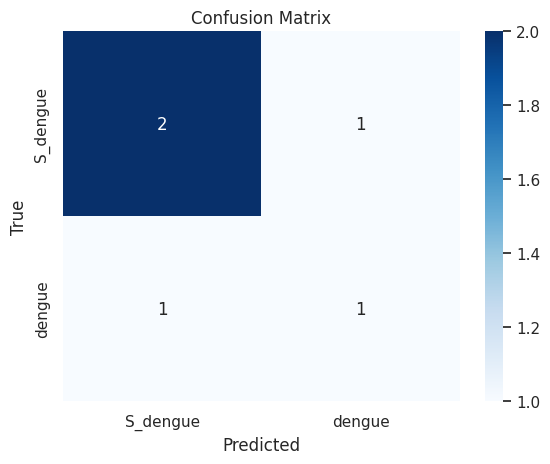

Top Biomarkers by Importance:
        gene  importance
5         F5    0.240821
3     FAM20A    0.203422
2      S100P    0.099338
7       PIM3    0.099147
6       PIM1    0.090010
9  LINC01001    0.089934
1         HP    0.073869
8      SOCS3    0.056762
0      VSIG4    0.033297
4       UTS2    0.013400


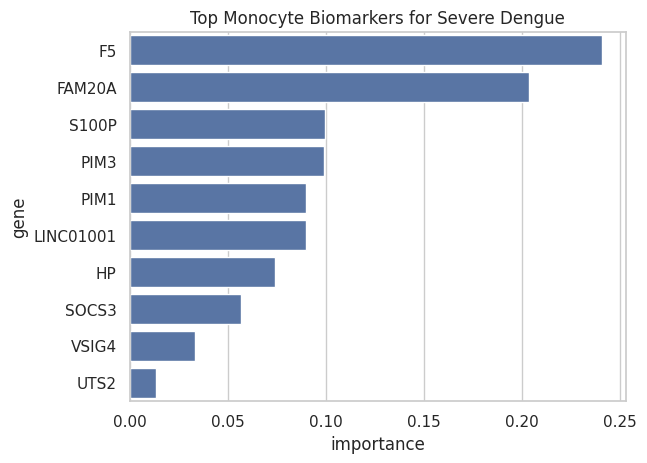

In [25]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your .h5ad (from your path)
adata = sc.read_h5ad('/content/drive/MyDrive/BioInfoResearch/GSE220969_dengue_kids.h5ad')

# Cell type
ct = 'Monocytes'

# Top DEGs from your run (extend to 50 if you have more; here top 10 for demo)
degs_ct = ['VSIG4', 'HP', 'S100P', 'FAM20A', 'UTS2', 'F5', 'PIM1', 'PIM3', 'SOCS3', 'LINC01001']  # Add more from deg_results_per_type[ct]

# Subset to Monocytes and conditions
adata_ct = adata[adata.obs['cell_type'] == ct]
mask = adata_ct.obs['condition'].isin(['dengue', 'S_dengue'])
adata_ct = adata_ct[mask]

# Patient aggregation
sample_col = 'ID'
patients = adata_ct.obs[sample_col].unique()

X = pd.DataFrame(index=patients, columns=degs_ct, dtype=float)
y = pd.Series(index=patients, dtype=str)

for pat in patients:
    mask_pat = adata_ct.obs[sample_col] == pat
    if mask_pat.sum() == 0:
        continue
    pat_adata = adata_ct[mask_pat]
    X.loc[pat] = pat_adata[:, degs_ct].X.mean(axis=0).A1
    y.loc[pat] = pat_adata.obs['condition'].iloc[0]

X = X.dropna()
y = y[X.index]

print("ML data shape:", X.shape)
print("Labels:", y.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=8)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
print("CV Mean Accuracy:", cv_scores.mean())

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (biomarkers)
importances = pd.DataFrame({'gene': degs_ct, 'importance': model.feature_importances_}).sort_values('importance', ascending=False).head(20)
print("Top Biomarkers by Importance:")
print(importances)

sns.barplot(x='importance', y='gene', data=importances)
plt.title('Top Monocyte Biomarkers for Severe Dengue')
plt.show()

In [26]:
import pandas as pd

# Your deg_results_per_type dict from earlier loop (assume it's still in memory)

# List of cell types to save (skip doublets/unknown/nan/megakaryocytes)
cell_types_to_save = ['B cells', 'NK cells', 'T cells', 'Monocytes', 'Plasmablasts', 'conventional DCs', 'plasmacytoid DCs']

# Manual list of potentially novel genes (expand based on your full top lists)
potential_novel_genes = ['FAM20A', 'PIM1', 'PIM3', 'UTS2', 'LINC01001', 'VSIG4']  # from Monocytes; add more from other types

# Create summary DataFrames
all_degs = []
novel_candidates = []

for ct in cell_types_to_save:
    if ct in deg_results_per_type and len(deg_results_per_type[ct]) > 0:
        df = deg_results_per_type[ct].copy()
        df['cell_type'] = ct

        # Top 20 per type
        top20 = df.head(20)[['names', 'logfoldchanges', 'pvals_adj']]
        top20['cell_type'] = ct
        all_degs.append(top20)

        # Novel candidates: intersection with your list + high logFC
        novel_in_ct = df[df['names'].isin(potential_novel_genes)]
        if not novel_in_ct.empty:
            novel_in_ct['cell_type'] = ct
            novel_candidates.append(novel_in_ct)

# Combine and save
if all_degs:
    all_df = pd.concat(all_degs, ignore_index=True)
    all_df = all_df[['cell_type', 'names', 'logfoldchanges', 'pvals_adj']]
    all_df.to_csv('/content/drive/MyDrive/BioInfoResearch/dengue_celltype_DEGs_top20.csv', index=False)
    print("Saved all top DEGs per cell type → dengue_celltype_DEGs_top20.csv")

if novel_candidates:
    novel_df = pd.concat(novel_candidates, ignore_index=True)
    novel_df = novel_df[['cell_type', 'names', 'logfoldchanges', 'pvals_adj']]
    novel_df.to_csv('/content/drive/MyDrive/BioInfoResearch/potential_novel_biomarkers.csv', index=False)
    print("Saved potential novel biomarkers → potential_novel_biomarkers.csv")
    print("\nPotential Novel Biomarkers Found:")
    print(novel_df)
else:
    print("No matches to potential novel list — check your full deg_results_per_type for new candidates.")

# Optional: Print Monocytes novel subset again
if 'Monocytes' in deg_results_per_type:
    print("\nMonocytes top novel candidates:")
    print(deg_results_per_type['Monocytes'][deg_results_per_type['Monocytes']['names'].isin(potential_novel_genes)][['names', 'logfoldchanges', 'pvals_adj']])

Saved all top DEGs per cell type → dengue_celltype_DEGs_top20.csv
Saved potential novel biomarkers → potential_novel_biomarkers.csv

Potential Novel Biomarkers Found:
          cell_type      names  logfoldchanges     pvals_adj
0           T cells       PIM3        1.568854  3.759273e-09
1           T cells       UTS2        1.383844  4.869668e-05
2         Monocytes      VSIG4        3.396917  6.078892e-03
3         Monocytes     FAM20A        2.508277  1.551597e-04
4         Monocytes       UTS2        2.472743  4.955922e-02
5         Monocytes       PIM1        2.178529  9.446282e-34
6         Monocytes       PIM3        2.153301  1.910939e-45
7         Monocytes  LINC01001        2.016112  1.735978e-02
8  conventional DCs       PIM1        3.719526  5.173375e-03

Monocytes top novel candidates:
          names  logfoldchanges     pvals_adj
731       VSIG4        3.396917  6.078892e-03
404      FAM20A        2.508277  1.551597e-04
1147       UTS2        2.472743  4.955922e-02
8     

/tmp/ipython-input-208/3820211099.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_in_ct['cell_type'] = ct
/tmp/ipython-input-208/3820211099.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_in_ct['cell_type'] = ct
/tmp/ipython-input-208/3820211099.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_